## Model-Based Collaborative Filtering
    - Implement model-based collaborative filtering algorithm with MovieLens dataset

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from surprise import Dataset, evaluate
from surprise import SVD
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate

In [2]:
ratings = pd.read_csv("ratings.csv", usecols = ['userId', 'movieId', 'rating'])
reader = Reader(rating_scale=(1, 5))

ratings = Dataset.load_from_df(ratings, reader)

raw_ratings = ratings.raw_ratings

random.Random(10).shuffle(raw_ratings)

threshold = int(.9 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

ratings.raw_ratings = A_raw_ratings

train_set = ratings.build_full_trainset()
test_set = ratings.construct_testset(B_raw_ratings)

## Matrix Factorization-based Collaborative Filtering
    - build SVD algorithm
    - evaluation metrics setup
        * cross-validation
        * accuracy on training and test set data
            a. RMSE
            b. MAE
        * coverage
            a. catalog-coverage
            b. user-coverage
            c. item-coverage

## Cross-Validation

In [3]:
#cross-validation iterator

algo = SVD()
cross_val = cross_validate(algo, ratings, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8848  0.8808  0.8752  0.8764  0.8758  0.8786  0.0037  
MAE (testset)     0.6785  0.6770  0.6744  0.6744  0.6764  0.6761  0.0016  
Fit time          4.84    4.73    4.78    4.75    4.75    4.77    0.04    
Test time         0.19    0.16    0.18    0.10    0.16    0.16    0.03    


## Accuracy on training and test data

In [4]:
algo = SVD()
algo.fit(train_set)

train_svd = algo.test(train_set.build_testset())
rmse = accuracy.rmse(train_svd)
mae = accuracy.mae(train_svd)

test_svd = algo.test(test_set)
rmse = accuracy.rmse(test_svd)
mae = accuracy.mae(test_svd)

RMSE: 0.6330
MAE:  0.4921
RMSE: 0.8572
MAE:  0.6566


## Coverage on training and test data
    In this case, we define an item is well-recommended if the recommended item has a rating greater than or equal to 4.5 given by this user in the test set.

    - item coverage:
        n = number of well-recommended items included in the recommedation list
        N = total number of potential items

        C_item = n/N * 100

    - User coverage:
        u = number of users for whom the recommender system was able to recommended at least k items well. 
        U = total number of potential users

        C_user = u/U * 100

    - Catalog coverage:
        T = number of items that are in the top-k for at least 1 user
        N = total number of potential items

        C_interaction = T/N * 100

In [5]:
#get top_n
from collections import defaultdict

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est, true_r))
    
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [6]:
#get the number of items in training and test

def get_inumber(predictions):
    '''Return the the number of items from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
    
    Returns:
    An integar presenting the number of items
    '''
    
    #create a list to store items
    number_items = []
    for uid, iid, true_r, est, _ in predictions:
        if iid not in number_items:
            number_items.append(iid)
    
    #return the length of list
    return len(number_items)

in_train = get_inumber(train_svd)
in_test = get_inumber(test_svd)
print ("Number of items in training set:", in_train)
print ("Number of items in test set:", in_test)



#get the number of users in training and test
def get_unumber(predictions):
    '''Return the the number of users from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
    
    Returns:
    An integar presenting the number of users
    '''
    
    #create a list to store users
    number_items = []
    for uid, iid, true_r, est, _ in predictions:
        if uid not in number_items:
            number_items.append(uid)
    
    #return the length of list
    return len(number_items)

un_train = get_unumber(train_svd)
un_test = get_unumber(test_svd)
print ("Number of users in training set:", un_train)
print ("Number of users in test set:",un_test)

Number of items in training set: 9338
Number of items in test set: 3622
Number of users in training set: 610
Number of users in test set: 601


In [7]:
#catalog-coverage for training set and test set

#get the top_n recommendation of training and test set
top_n_train = get_top_n(train_svd, n=10)
top_n_test = get_top_n(test_svd, n=10)

#create a list to store the items recommended
cata_cov_train = []
for i in range(1, len(top_n_train) + 1, 1):
    for item in top_n_train[i]:
        if item[0] not in cata_cov_train:
            cata_cov_train.append(item[0])
print ("Catalog-coverage of training set:", float(len(cata_cov_train)) / float(in_train))

cata_cov_test = []
for i in range(1, len(top_n_test) + 1, 1):
    for item in top_n_test[i]:
        if item[0] not in cata_cov_test:
            cata_cov_test.append(item[0])
print ("Catalog-coverage of test set:", float(len(cata_cov_test)) / float(in_test))

Catalog-coverage of training set: 0.10152066823730992
Catalog-coverage of test set: 0.38597459966869135


In [8]:
#user-coverage for training set and test set
def user_cov(top_n, k = 5):
    '''Return the the number of users for which at least k items' ratings reach 4.5 from a recommendation dict.

    Args:
        top_n (A dict where keys are user (raw) ids and values are lists of tuples):
        [(raw item id, rating estimation), ...] of size n.
        k (int): Default is 5.
    
    Returns:
    An integar presenting the number of users
    '''
    
    #create a dict to store the users' recommended items whose ratings reach 4.5
    #count = count + 1 if the i-th user has more than k recommended well items
    user_cover = defaultdict(list)
    count = 0
    for i in range(len(top_n)):
        for item in top_n[i]:
            if item[2] >= 4.5:
                user_cover[i].append(item)
        if len(user_cover[i]) >= k:
            count += 1
    return count

user_cov_train = user_cov(top_n_train)
user_cov_test = user_cov(top_n_test)

print ("User-coverage of training set:", float(user_cov_train) / float(un_train))
print ("User-coverage of test set:", float(user_cov_test) / float(un_test))

User-coverage of training set: 0.7885245901639344
User-coverage of test set: 0.1713810316139767


In [9]:
#item-coverage for training set and test set
def item_cov(top_n, n, k = 1):
    '''Return the the number of items at least recommended to k users 
       whose ratings reach 4.5 from a recommendation dict.

    Args:
        top_n (A dict where keys are user (raw) ids and values are lists of tuples):
        [(raw item id, rating estimation), ...] of size n.
        n (int): the total number of items of the dataset.
        k (int): Default is 5.
    
    Returns:
    An integar presenting the number of users
    '''
    
    #create a dict to store the items whose ratings reach 4.5 and the users they're recommended to
    item_cover = defaultdict(list)
    count = 0
    for i in range(len(top_n)):
        for item in top_n[i]:
            if item[2] >= 4.5:
                item_cover[item[0]].append(item)
                
    #count = count + 1 if the i-th item has more than k users
    for i in range(n):
        if len(item_cover[i]) >= k:
            count += 1
    return count

item_cov_train = item_cov(top_n_train, in_train)
item_cov_test = item_cov(top_n_test, in_test)
print ("Item-coverage of training set:",float(item_cov_train) / float(in_train))
print ("Item-coverage of test set:", float(item_cov_test) / float(in_test))

Item-coverage of training set: 0.06307560505461556
Item-coverage of test set: 0.10160132523467698


## Tune the parameters
    - Our hyper parameters including:
        a. the number of latent dimensions
        b. the number of iteration of the SGD procedure
        c. the learning rate for all parameters
        d. the regularization term for all parameters
    - We will tune the parameters and explore the relationships between them and accuracy/coverage.

In [10]:
#create a list of latent dimensions
num_k = range(5, 155, 5)
RMSE_train = []
RMSE_test = []
MAE_train = []
MAE_test = []
c_cov_train = []
c_cov_test = []
u_cov_train = []
u_cov_test = []
i_cov_train = []
i_cov_test = []
print("Compare different latent dimensions")
for k in num_k:
    #train the model
    algo = SVD(n_factors = k)
    algo.fit(train_set)
    
    #calculate the rmse and mae of training and test
    train_svd = algo.test(train_set.build_testset())
    rmse = accuracy.rmse(train_svd, verbose = False)
    mae = accuracy.mae(train_svd, verbose = False)
    RMSE_train.append(round(rmse, 4))
    MAE_train.append(round(mae, 4))

    test_svd = algo.test(test_set)
    rmse = accuracy.rmse(test_svd, verbose = False)
    mae = accuracy.mae(test_svd, verbose = False)
    RMSE_test.append(round(rmse, 4))
    MAE_test.append(round(mae, 4))
    
    #catalog-coverage for training set and test set
    top_n_train = get_top_n(train_svd, n=10)
    top_n_test = get_top_n(test_svd, n=10)

    cata_cov_train = []
    for i in range(1, len(top_n_train) + 1, 1):
        for item in top_n_train[i]:
            if item[0] not in cata_cov_train:
                cata_cov_train.append(item[0])
    c_cov_train.append(float(len(cata_cov_train)) / float(in_train))

    cata_cov_test = []
    for i in range(1, len(top_n_test) + 1, 1):
        for item in top_n_test[i]:
            if item[0] not in cata_cov_test:
                cata_cov_test.append(item[0])
    c_cov_test.append(float(len(cata_cov_test)) / float(in_test))
    
    #user-coverage for training and test set
    user_cov_train = user_cov(top_n_train)
    user_cov_test = user_cov(top_n_test)

    u_cov_train.append(float(user_cov_train) / float(un_train))
    u_cov_test.append(float(user_cov_test) / float(un_test))
    
    #item-coverage for training and test set
    item_cov_train = item_cov(top_n_train, in_train)
    item_cov_test = item_cov(top_n_test, in_test)
    
    i_cov_train.append(float(item_cov_train) / float(in_train))
    i_cov_test.append(float(item_cov_test) / float(in_test))
    

RMSE_factors = pd.DataFrame(
    {'Number_of_dimension': num_k,
     'RMSE_train': RMSE_train,
     'RMSE_test': RMSE_test,
     'MAE_train': MAE_train,
     'MAE_test': MAE_test,
     'Catalog_Coverage_train': c_cov_train,
     'Catalog_Coverage_test': c_cov_test,
     'User_Coverage_train': u_cov_train,
     'User_Coverage_test': u_cov_test,
     'Item_Coverage_train': i_cov_train,
     'Item_Coverage_test': i_cov_test
    })

Compare different latent dimensions


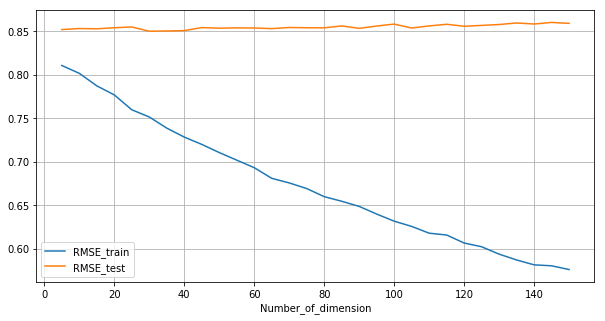

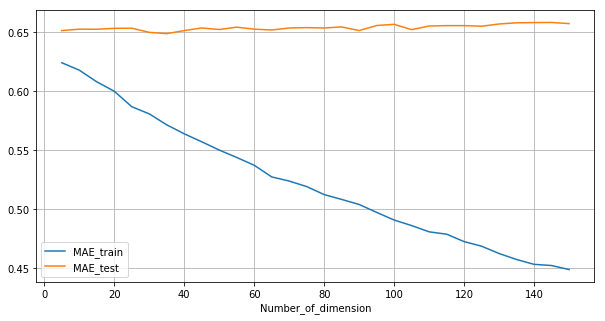

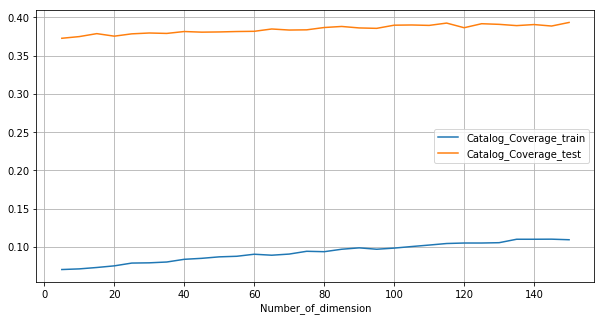

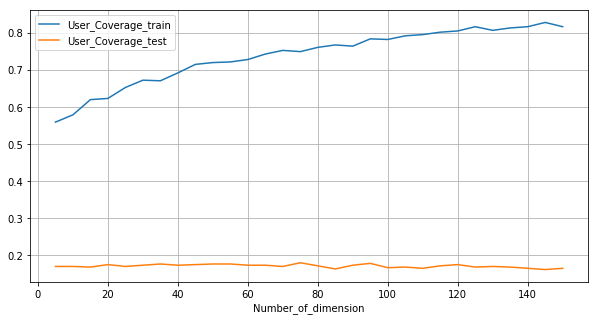

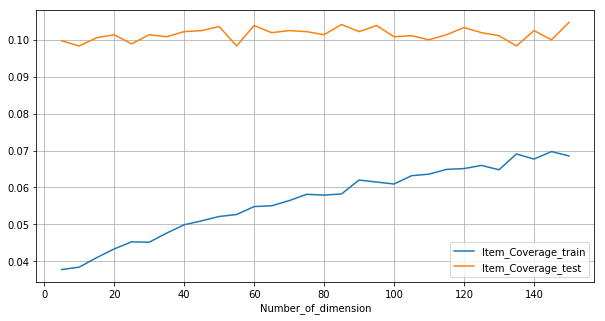

In [11]:
fig = RMSE_factors.plot(x = 'Number_of_dimension', y = ['RMSE_train', 'RMSE_test'],figsize = (10,5), grid = True)
plt.show()
fig = RMSE_factors.plot(x = 'Number_of_dimension', y = ['MAE_train', 'MAE_test'],figsize = (10,5), grid = True)
plt.show()
fig = RMSE_factors.plot(x = 'Number_of_dimension', y = ['Catalog_Coverage_train', 'Catalog_Coverage_test'],figsize = (10,5), grid = True)
plt.show()
fig = RMSE_factors.plot(x = 'Number_of_dimension', y = ['User_Coverage_train', 'User_Coverage_test'],figsize = (10,5), grid = True)
plt.show()
fig = RMSE_factors.plot(x = 'Number_of_dimension', y = ['Item_Coverage_train', 'Item_Coverage_test'],figsize = (10,5), grid = True)
plt.show()

### Results
    According to the plots, we can see that the accuracy and coverage of test data is rather stable as the increase of latent dimensions. It is probably because there is little difference for test data when the latent dimensions change. As for training set, there is an obvious trend of decrease in RMSE and MAE, which means that the bigger the latent dimensions are, the better the training set behaves, agreeing with our intuition. And there is also a trend of increase in coverage of training set.

In [12]:
#Compare the number of iteration of the SGD procedure
num_k = range(5, 85 ,5)
RMSE_train = []
RMSE_test = []
MAE_train = []
MAE_test = []
c_cov_train = []
c_cov_test = []
u_cov_train = []
u_cov_test = []
i_cov_train = []
i_cov_test = []
print("Compare the number of iteration of the SGD procedure")
for k in num_k:
    #train the model
    algo = SVD(n_epochs = k)
    algo.fit(train_set)
    
    #calculate the rmse and mae of training and test
    train_svd = algo.test(train_set.build_testset())
    rmse = accuracy.rmse(train_svd, verbose = False)
    mae = accuracy.mae(train_svd, verbose = False)
    RMSE_train.append(round(rmse, 4))
    MAE_train.append(round(mae, 4))

    test_svd = algo.test(test_set)
    rmse = accuracy.rmse(test_svd, verbose = False)
    mae = accuracy.mae(test_svd, verbose = False)
    RMSE_test.append(round(rmse, 4))
    MAE_test.append(round(mae, 4))
    
    #catalog-coverage for training set and test set
    top_n_train = get_top_n(train_svd, n=10)
    top_n_test = get_top_n(test_svd, n=10)

    cata_cov_train = []
    for i in range(1, len(top_n_train) + 1, 1):
        for item in top_n_train[i]:
            if item[0] not in cata_cov_train:
                cata_cov_train.append(item[0])
    c_cov_train.append(float(len(cata_cov_train)) / float(in_train))

    cata_cov_test = []
    for i in range(1, len(top_n_test) + 1, 1):
        for item in top_n_test[i]:
            if item[0] not in cata_cov_test:
                cata_cov_test.append(item[0])
    c_cov_test.append(float(len(cata_cov_test)) / float(in_test))
    
    #user-coverage for training and test set
    user_cov_train = user_cov(top_n_train)
    user_cov_test = user_cov(top_n_test)

    u_cov_train.append(float(user_cov_train) / float(un_train))
    u_cov_test.append(float(user_cov_test) / float(un_test))
    
    #item-coverage for training and test set
    item_cov_train = item_cov(top_n_train, in_train)
    item_cov_test = item_cov(top_n_test, in_test)
    
    i_cov_train.append(float(item_cov_train) / float(in_train))
    i_cov_test.append(float(item_cov_test) / float(in_test))

RMSE_epochs = pd.DataFrame(
    {'Number_of_iteration': num_k,
     'RMSE_train': RMSE_train,
     'RMSE_test': RMSE_test,
     'MAE_train': MAE_train,
     'MAE_test': MAE_test,
     'Catalog_Coverage_train': c_cov_train,
     'Catalog_Coverage_test': c_cov_test,
     'User_Coverage_train': u_cov_train,
     'User_Coverage_test': u_cov_test,
     'Item_Coverage_train': i_cov_train,
     'Item_Coverage_test': i_cov_test
    })

Compare the number of iteration of the SGD procedure


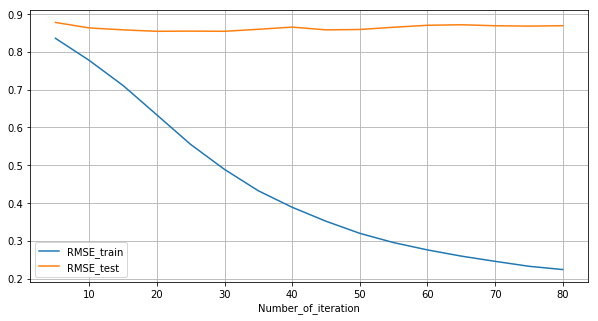

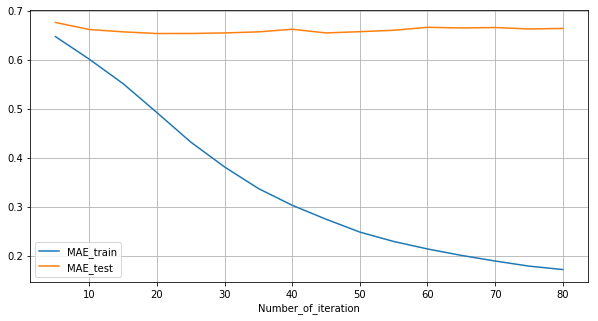

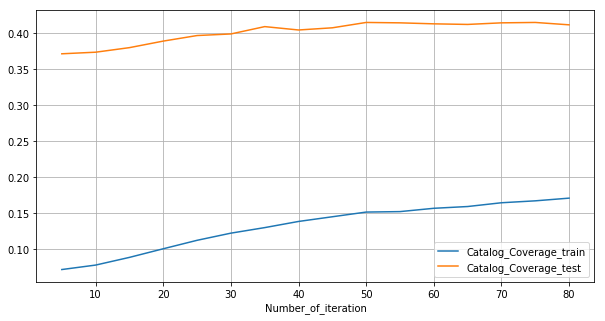

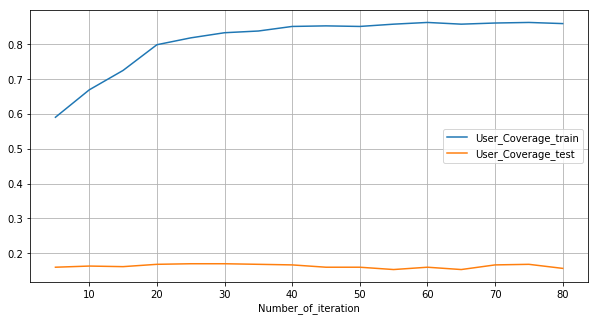

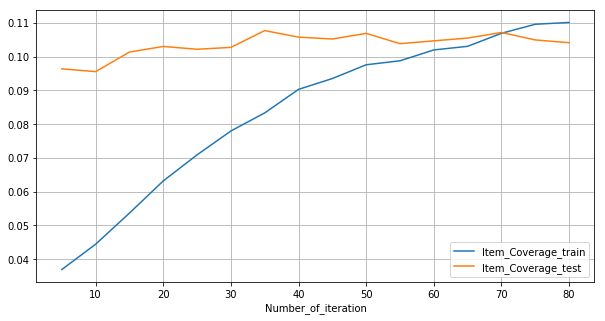

In [13]:
fig = RMSE_epochs.plot(x = 'Number_of_iteration', y = ['RMSE_train', 'RMSE_test'],figsize = (10,5), grid = True)
plt.show()
fig = RMSE_epochs.plot(x = 'Number_of_iteration', y = ['MAE_train', 'MAE_test'],figsize = (10,5), grid = True)
plt.show()
fig = RMSE_epochs.plot(x = 'Number_of_iteration', y = ['Catalog_Coverage_train', 'Catalog_Coverage_test'],figsize = (10,5), grid = True)
plt.show()
fig = RMSE_epochs.plot(x = 'Number_of_iteration', y = ['User_Coverage_train', 'User_Coverage_test'],figsize = (10,5), grid = True)
plt.show()
fig = RMSE_epochs.plot(x = 'Number_of_iteration', y = ['Item_Coverage_train', 'Item_Coverage_test'],figsize = (10,5), grid = True)
plt.show()

### Results
    According to the plots, we can see that the accuracy and user-coverage of test data is relatively stable as the increase of the number of iterations of the SGD procedure. When comes to coverage, we can see a slight increase of catalog-coverage and item coverage in test data, it is probably because that the number of items recommended well has an increase. As for training set, same as latent dimensions, there are an obvious increase and decrease in all the metrics.

In [14]:
#Compare the learning rate for all parameters
num_k = np.arange(0.0005, 0.0105, 0.0005)
RMSE_train = []
RMSE_test = []
MAE_train = []
MAE_test = []
c_cov_train = []
c_cov_test = []
u_cov_train = []
u_cov_test = []
i_cov_train = []
i_cov_test = []
print("Compare the learning rate for all parameters")
for k in num_k:
    #train the model
    algo = SVD(lr_all = k)
    algo.fit(train_set)
    
    #calculate the rmse and mae of training and test
    train_svd = algo.test(train_set.build_testset())
    rmse = accuracy.rmse(train_svd, verbose = False)
    mae = accuracy.mae(train_svd, verbose = False)
    RMSE_train.append(round(rmse, 4))
    MAE_train.append(round(mae, 4))

    test_svd = algo.test(test_set)
    rmse = accuracy.rmse(test_svd, verbose = False)
    mae = accuracy.mae(test_svd, verbose = False)
    RMSE_test.append(round(rmse, 4))
    MAE_test.append(round(mae, 4))
    
    #catalog-coverage for training set and test set
    top_n_train = get_top_n(train_svd, n=10)
    top_n_test = get_top_n(test_svd, n=10)

    cata_cov_train = []
    for i in range(1, len(top_n_train) + 1, 1):
        for item in top_n_train[i]:
            if item[0] not in cata_cov_train:
                cata_cov_train.append(item[0])
    c_cov_train.append(float(len(cata_cov_train)) / float(in_train))

    cata_cov_test = []
    for i in range(1, len(top_n_test) + 1, 1):
        for item in top_n_test[i]:
            if item[0] not in cata_cov_test:
                cata_cov_test.append(item[0])
    c_cov_test.append(float(len(cata_cov_test)) / float(in_test))
    
    #user-coverage for training and test set
    user_cov_train = user_cov(top_n_train)
    user_cov_test = user_cov(top_n_test)

    u_cov_train.append(float(user_cov_train) / float(un_train))
    u_cov_test.append(float(user_cov_test) / float(un_test))
    
    #item-coverage for training and test set
    item_cov_train = item_cov(top_n_train, in_train)
    item_cov_test = item_cov(top_n_test, in_test)
    
    i_cov_train.append(float(item_cov_train) / float(in_train))
    i_cov_test.append(float(item_cov_test) / float(in_test))

RMSE_lr = pd.DataFrame(
    {'Learning_rate': num_k,
     'RMSE_train': RMSE_train,
     'RMSE_test': RMSE_test,
     'MAE_train': MAE_train,
     'MAE_test': MAE_test,
     'Catalog_Coverage_train': c_cov_train,
     'Catalog_Coverage_test': c_cov_test,
     'User_Coverage_train': u_cov_train,
     'User_Coverage_test': u_cov_test,
     'Item_Coverage_train': i_cov_train,
     'Item_Coverage_test': i_cov_test
    })

Compare the learning rate for all parameters


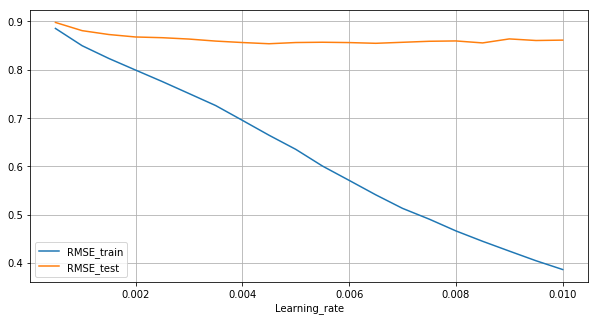

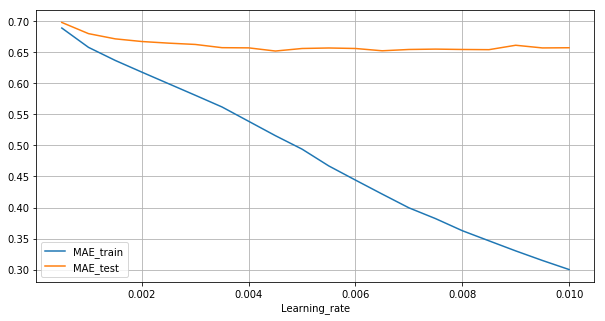

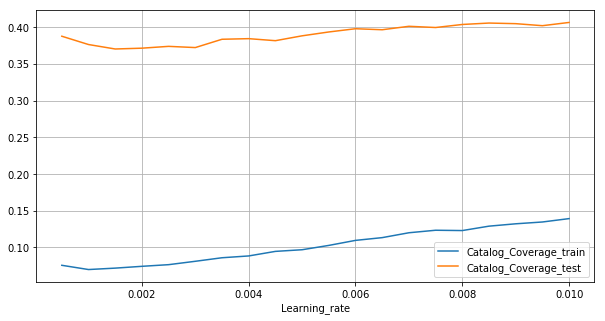

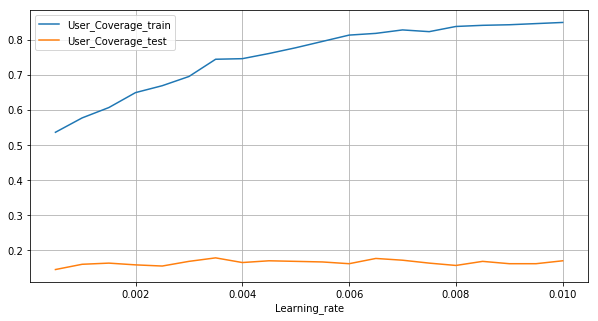

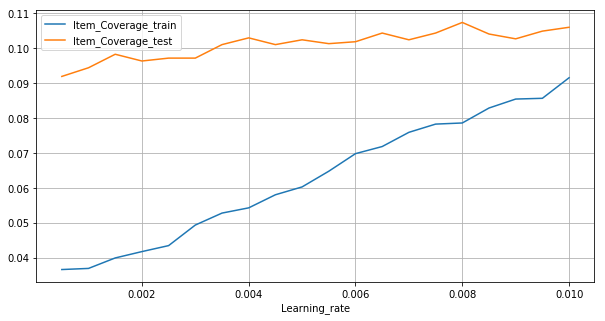

In [15]:
fig = RMSE_lr.plot(x = 'Learning_rate', y = ['RMSE_train', 'RMSE_test'],figsize = (10,5), grid = True)
plt.show()
fig = RMSE_lr.plot(x = 'Learning_rate', y = ['MAE_train', 'MAE_test'],figsize = (10,5), grid = True)
plt.show()
fig = RMSE_lr.plot(x = 'Learning_rate', y = ['Catalog_Coverage_train', 'Catalog_Coverage_test'],figsize = (10,5), grid = True)
plt.show()
fig = RMSE_lr.plot(x = 'Learning_rate', y = ['User_Coverage_train', 'User_Coverage_test'],figsize = (10,5), grid = True)
plt.show()
fig = RMSE_lr.plot(x = 'Learning_rate', y = ['Item_Coverage_train', 'Item_Coverage_test'],figsize = (10,5), grid = True)
plt.show()

### Results
    According to the plots, we can see that the accuracy of test data has a slight decrease along with the increase of learning rate. When comes to coverage, we can see a slight increase of catalog-coverage and item coverage in test data, it is probably because that the number of items recommended well has an increase. As for training set, same as latent dimensions, there are an obvious increase and decrease in all the metrics.

In [16]:
#Compare the regularization term for all parameters
num_k = np.arange(0.005, 0.105, 0.005)
RMSE_train = []
RMSE_test = []
MAE_train = []
MAE_test = []
c_cov_train = []
c_cov_test = []
u_cov_train = []
u_cov_test = []
i_cov_train = []
i_cov_test = []
print("Compare the regularization term for all parameters")
for k in num_k:
    #train the model
    algo = SVD(reg_all = k)
    algo.fit(train_set)
    
    #calculate the rmse and mae of training and test
    train_svd = algo.test(train_set.build_testset())
    rmse = accuracy.rmse(train_svd, verbose = False)
    mae = accuracy.mae(train_svd, verbose = False)
    RMSE_train.append(round(rmse, 4))
    MAE_train.append(round(mae, 4))

    test_svd = algo.test(test_set)
    rmse = accuracy.rmse(test_svd, verbose = False)
    mae = accuracy.mae(test_svd, verbose = False)
    RMSE_test.append(round(rmse, 4))
    MAE_test.append(round(mae, 4))
    
    #catalog-coverage for training set and test set
    top_n_train = get_top_n(train_svd, n=10)
    top_n_test = get_top_n(test_svd, n=10)

    cata_cov_train = []
    for i in range(1, len(top_n_train) + 1, 1):
        for item in top_n_train[i]:
            if item[0] not in cata_cov_train:
                cata_cov_train.append(item[0])
    c_cov_train.append(float(len(cata_cov_train)) / float(in_train))

    cata_cov_test = []
    for i in range(1, len(top_n_test) + 1, 1):
        for item in top_n_test[i]:
            if item[0] not in cata_cov_test:
                cata_cov_test.append(item[0])
    c_cov_test.append(float(len(cata_cov_test)) / float(in_test))
    
    #user-coverage for training and test set
    user_cov_train = user_cov(top_n_train)
    user_cov_test = user_cov(top_n_test)

    u_cov_train.append(float(user_cov_train) / float(un_train))
    u_cov_test.append(float(user_cov_test) / float(un_test))
    
    #item-coverage for training and test set
    item_cov_train = item_cov(top_n_train, in_train)
    item_cov_test = item_cov(top_n_test, in_test)
    
    i_cov_train.append(float(item_cov_train) / float(in_train))
    i_cov_test.append(float(item_cov_test) / float(in_test))

RMSE_reg = pd.DataFrame(
    {'Reg_term': num_k,
     'RMSE_train': RMSE_train,
     'RMSE_test': RMSE_test,
     'MAE_train': MAE_train,
     'MAE_test': MAE_test,
     'Catalog_Coverage_train': c_cov_train,
     'Catalog_Coverage_test': c_cov_test,
     'User_Coverage_train': u_cov_train,
     'User_Coverage_test': u_cov_test,
     'Item_Coverage_train': i_cov_train,
     'Item_Coverage_test': i_cov_test
    })

Compare the regularization term for all parameters


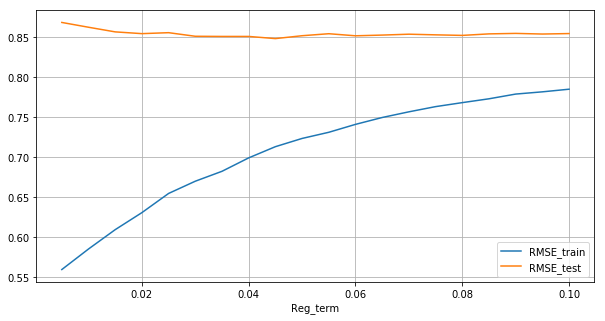

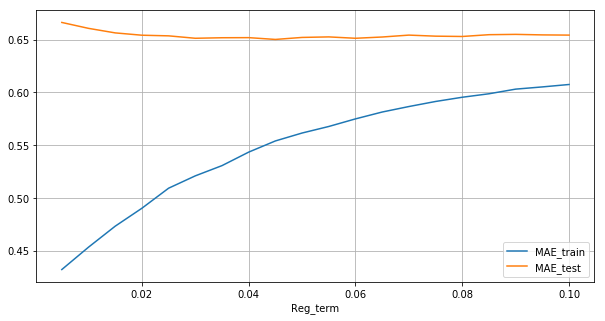

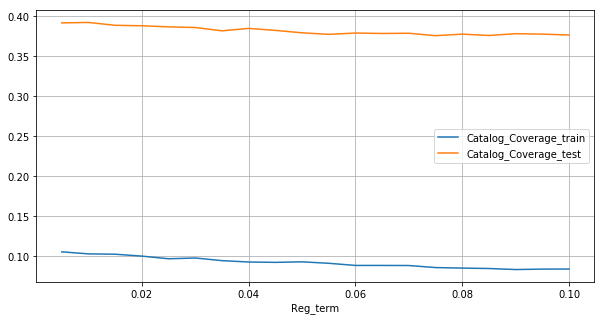

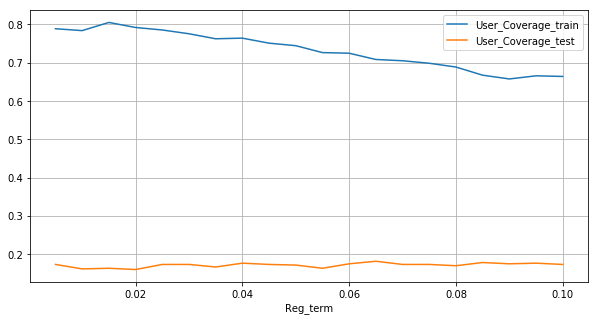

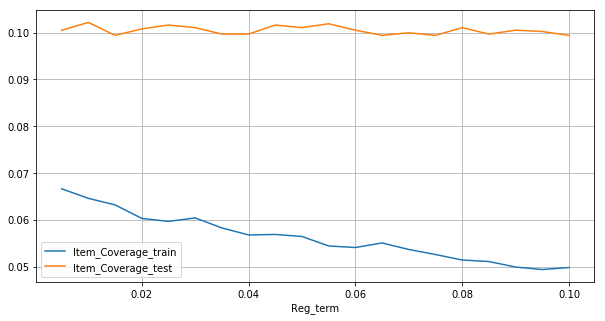

In [17]:
fig = RMSE_reg.plot(x = 'Reg_term', y = ['RMSE_train', 'RMSE_test'],figsize = (10,5), grid = True)
plt.show()
fig = RMSE_reg.plot(x = 'Reg_term', y = ['MAE_train', 'MAE_test'],figsize = (10,5), grid = True)
plt.show()
fig = RMSE_reg.plot(x = 'Reg_term', y = ['Catalog_Coverage_train', 'Catalog_Coverage_test'],figsize = (10,5), grid = True)
plt.show()
fig = RMSE_reg.plot(x = 'Reg_term', y = ['User_Coverage_train', 'User_Coverage_test'],figsize = (10,5), grid = True)
plt.show()
fig = RMSE_reg.plot(x = 'Reg_term', y = ['Item_Coverage_train', 'Item_Coverage_test'],figsize = (10,5), grid = True)
plt.show()

### Results
    According to the plots, we can see that the accuracy and catalog-coverage of test data has a slight decrease along with the increase of regularization term. And the user-coverage and item-coverage is relatively stable. As for training set, there is an obvious trend of increase of RMSE and MAE, and the coverage metrics all have a slight decrease, which indicates that it doesn't behave better when regularization term increases for training data.

## Explore the relationship between model size and accuracy/run-time
    - Try different subsets of the whole dataset
    - Calculate accuracy, coverage and run-time for each subset
    - Compare by the size of each subset

In [18]:
import time
Ratings = pd.read_csv("ratings.csv", usecols = ['userId', 'movieId', 'rating'])
print(type(ratings))

RMSE_train = []
RMSE_test = []
MAE_train = []
MAE_test = []
c_cov_train = []
c_cov_test = []
u_cov_train = []
u_cov_test = []
i_cov_train = []
i_cov_test = []
execution_time = []

sub = np.arange(0.1, 1.1, 0.1)
for prop in sub:
    start_time = time.time()
    ratings_sub = Ratings.sample(frac = prop, random_state = 4571)
    reader = Reader(rating_scale=(1, 5))
    ratings = Dataset.load_from_df(ratings_sub, reader)
    raw_ratings = ratings.raw_ratings
    random.Random(10).shuffle(raw_ratings)
    threshold = int(.9 * len(raw_ratings))
    A_raw_ratings = raw_ratings[:threshold]
    B_raw_ratings = raw_ratings[threshold:]
    ratings.raw_ratings = A_raw_ratings

    train_set = ratings.build_full_trainset()
    test_set = ratings.construct_testset(B_raw_ratings)

    #train the model
    algo = SVD()
    algo.fit(train_set)
    
    #calculate the rmse and mae of training and test
    train_svd = algo.test(train_set.build_testset())
    rmse = accuracy.rmse(train_svd, verbose = False)
    mae = accuracy.mae(train_svd, verbose = False)
    RMSE_train.append(round(rmse, 4))
    MAE_train.append(round(mae, 4))

    test_svd = algo.test(test_set)
    rmse = accuracy.rmse(test_svd, verbose = False)
    mae = accuracy.mae(test_svd, verbose = False)
    RMSE_test.append(round(rmse, 4))
    MAE_test.append(round(mae, 4))
    
    #catalog-coverage for training set and test set
    top_n_train = get_top_n(train_svd, n=10)
    top_n_test = get_top_n(test_svd, n=10)

    cata_cov_train = []
    for i in range(1, len(top_n_train) + 1, 1):
        for item in top_n_train[i]:
            if item[0] not in cata_cov_train:
                cata_cov_train.append(item[0])
    c_cov_train.append(float(len(cata_cov_train)) / float(in_train))

    cata_cov_test = []
    for i in range(1, len(top_n_test) + 1, 1):
        for item in top_n_test[i]:
            if item[0] not in cata_cov_test:
                cata_cov_test.append(item[0])
    c_cov_test.append(float(len(cata_cov_test)) / float(in_test))
    
    #user-coverage for training and test set
    user_cov_train = user_cov(top_n_train)
    user_cov_test = user_cov(top_n_test)

    u_cov_train.append(float(user_cov_train) / float(un_train))
    u_cov_test.append(float(user_cov_test) / float(un_test))
    
    #item-coverage for training and test set
    item_cov_train = item_cov(top_n_train, in_train)
    item_cov_test = item_cov(top_n_test, in_test)
    
    i_cov_train.append(float(item_cov_train) / float(in_train))
    i_cov_test.append(float(item_cov_test) / float(in_test))



    #record execution time
    exe_time = time.time() - start_time
    execution_time.append(round(exe_time, 4))
    
model_size = pd.DataFrame(
    {'Sample_size': sub,
     'Running_time': execution_time,
     'RMSE_train': RMSE_train,
     'RMSE_test': RMSE_test,
     'MAE_train': MAE_train,
     'MAE_test': MAE_test,
     'Catalog_Coverage_train': c_cov_train,
     'Catalog_Coverage_test': c_cov_test,
     'User_Coverage_train': u_cov_train,
     'User_Coverage_test': u_cov_test,
     'Item_Coverage_train': i_cov_train,
     'Item_Coverage_test': i_cov_test
    })
print(model_size)

<class 'surprise.dataset.DatasetAutoFolds'>
   Sample_size  Running_time  RMSE_train  RMSE_test  MAE_train  MAE_test  \
0          0.1        0.8077      0.6684     0.9174     0.5221    0.7184   
1          0.2        1.5374      0.6630     0.9270     0.5169    0.7189   
2          0.3        2.2368      0.6536     0.9338     0.5101    0.7223   
3          0.4        2.9585      0.6475     0.9008     0.5047    0.7000   
4          0.5        3.8018      0.6445     0.8900     0.5016    0.6901   
5          0.6        4.5284      0.6486     0.8935     0.5034    0.6916   
6          0.7        5.2799      0.6432     0.8889     0.4989    0.6910   
7          0.8        6.2117      0.6428     0.8864     0.4987    0.6889   
8          0.9        6.7773      0.6368     0.8775     0.4942    0.6798   
9          1.0        7.5918      0.6302     0.8786     0.4890    0.6795   

   Catalog_Coverage_train  Catalog_Coverage_test  User_Coverage_train  \
0                0.159456               0.1162

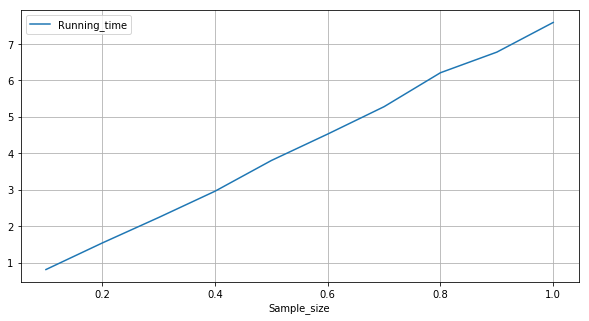

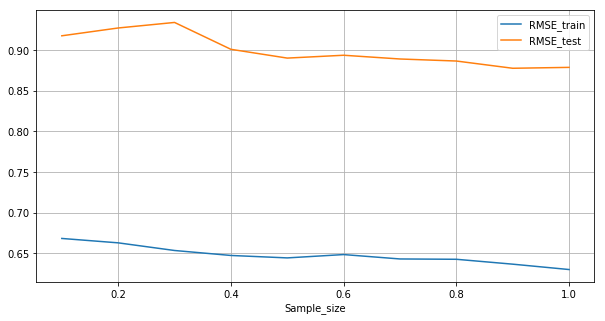

In [19]:
fig = model_size.plot(x = 'Sample_size', y = ['Running_time'],figsize = (10,5), grid = True)
plt.show()
fig = model_size.plot(x = 'Sample_size', y = ['RMSE_train', 'RMSE_test'],figsize = (10,5), grid = True)
plt.show()

### Results
    The overall accuracy goes up (the RMSE goes down) when the sample size is increasing, which meets our expectation. And there is a linear relation between the sample size and running time.

## Conclusion

 In this project we implemented SVD algorithm and applied it to the MovieLens dataset. When we compare the result with item-based CF algorithm achieves, we would find that SVD provides a more accurate and more efficient solution of this problem.